In [283]:
from pathlib import Path
from tabulate import tabulate

from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator

from support_mvp.backup_plot_diagram.ref_energies import get_xtbreaction_thermal
from support_mvp.backup_plot_diagram.data_handler import (
    combine_dict_values,
    get_delta_gibbs,
    get_energies_Mo,
    read_parts,
)
from support_mvp.backup_plot_diagram.plot_diagram_schrock import (
    HARTREE2KCAL,
    base,
    collection,
    dicts,
)
import numpy as np
from sklearn.metrics import r2_score

font = {"size": 18}

plt.rc("font", **font)

In [284]:
# Adjust troublesome values
# compare_data['b3lyp_candidate']['Mo_N'] = 0

# colors = cmap.colorsco
# colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
colors = ["k", "#1f77b4", "0.80"]  # Could also use the color generator above

# Get the reference energy dicts.
dicts = read_parts()

In [285]:
def format_value(value, decimals):
    """ 
    Checks the type of a variable and formats it accordingly.
    Floats has 'decimals' number of decimals.
    """
    
    if isinstance(value, (float, float)):
        return f'{value:.{decimals}f}'
    elif isinstance(value, (int, np.integer)):
        return f'{value:d}'
    else:
        return f'{value}'


def values_to_string(values, decimals):
    """ 
    Loops over all elements of 'values' and returns list of strings
    with proper formating according to the function 'format_value'. 
    """
    
    res = []
    for value in values:
        if isinstance(value, list):
            tmp = [format_value(val, decimals) for val in value]
            res.append(f'{tmp[0]} +/- {tmp[1]}')
        else:
            res.append(format_value(value, decimals))
    return res


def len_of_longest_string(s):
    """ Returns the length of the longest string in a list of strings """
    return len(max(s, key=len))


def nice_string_output(d, extra_spacing=5, decimals=3):
    """ 
    Takes a dictionary d consisting of names and values to be properly formatted.
    Makes sure that the distance between the names and the values in the printed
    output has a minimum distance of 'extra_spacing'. One can change the number
    of decimals using the 'decimals' keyword.  
    """
    
    names = d.keys()
    max_names = len_of_longest_string(names)
    
    values = values_to_string(d.values(), decimals=decimals)
    max_values = len_of_longest_string(values)
    
    string = ""
    for name, value in zip(names, values):
        spacing = extra_spacing + max_values + max_names - len(name) - 1 
        string += "{name:s} {value:>{spacing}} \n".format(name=name, value=value, spacing=spacing)
    return string[:-2]


def add_text_to_ax(x_coord, y_coord, string, ax, fontsize=12, color='k'):
    """ Shortcut to add text to an ax with proper font. Relative coords."""
    ax.text(x_coord, y_coord, string, family='monospace', fontsize=fontsize,
            transform=ax.transAxes, verticalalignment='top', color=color)
    return None

## Thermal plot

In [286]:
def thermal_plot2():
    xtb_thermal = get_xtbreaction_thermal(Path("/home/magstr/Documents/schrock/diagrams_schrock/vibrations_original_xtb/"))
    paper_thermal = collection["paper_thermal_corrections"]

    xtb = []
    dft = []
    label=[]
    cmap = cm.get_cmap("tab20")
    colors=cmap.colors
    #colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    for key, val in xtb_thermal.items():
        xtb.append(val)
        dft.append(paper_thermal[key])
        label.append(key)
    plt.figure(figsize=(14, 8))
    plt.plot(dft, dft, "")
    for x,y,label,color in zip(dft,xtb,label, colors):
        plt.plot(x, y, 'o', label=label, markersize='20', color=color)
    plt.ylabel("xTB (kcal/mol) - This work")
    plt.xlabel("B3LYP (kcal/mol) - Reference paper")
    plt.title(f"")
    ax = plt.gca()
    
    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),prop={'size': 22})
    
    
    R2 = r2_score(dft, xtb)
    
    d = {'R² = ':R2}

    text = nice_string_output(d, extra_spacing=2, decimals=3)
    add_text_to_ax(0.04, 0.95, text, ax, fontsize=20)
    
    plt.savefig("/home/magstr/Documents/Paper/figures/xtb_correlation.pdf")
    plt.show()
    return

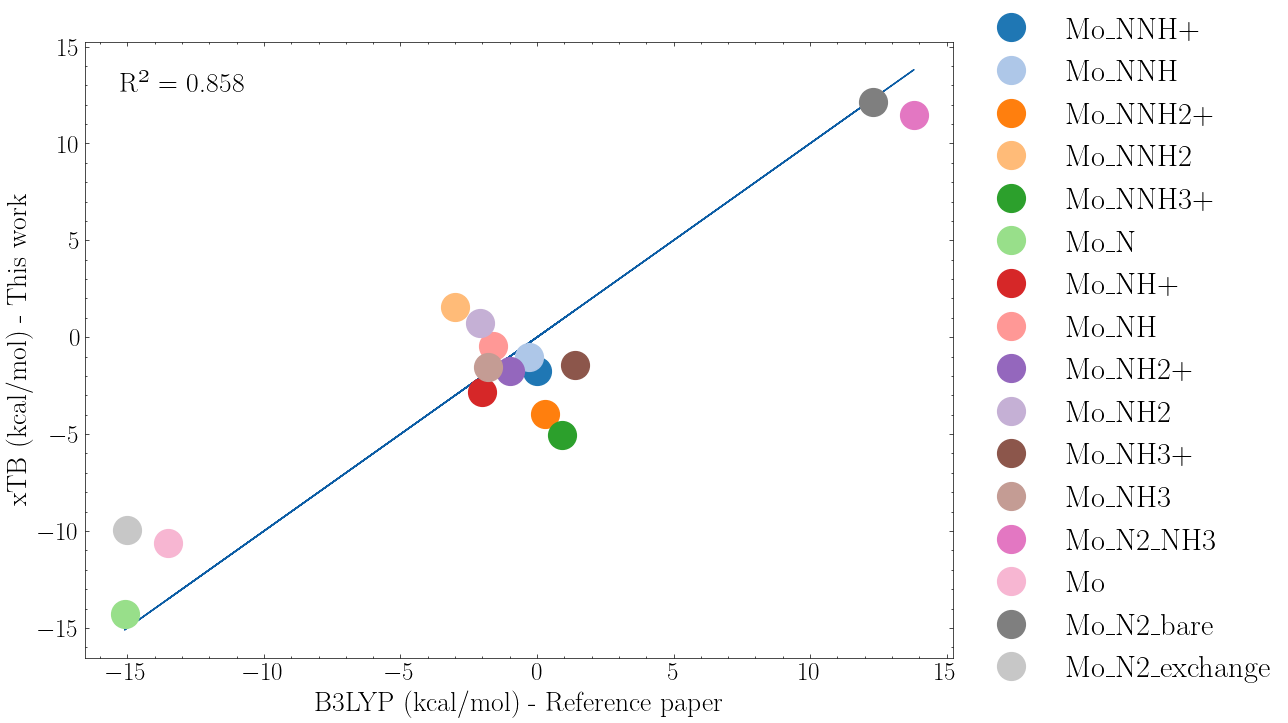

In [287]:
thermal_plot2()


## Reaction step correlation 

In [288]:
def compare_step_vals_G():

    b3lyp_G = collection["paper_b3lyp_reaction_G"]
    xtb_thermal = get_xtbreaction_thermal(Path("/home/magstr/Documents/schrock/diagrams_schrock/vibrations_original_xtb/"))

    dict_key = "parts_radius_b3lyp_nogeo"
    diagrams = [
        [
            base / "schrock/diagrams_schrock/dft/b3lyp_sp",
            "orca.out",
            "FINAL SINGLE",
            dicts[dict_key],
        ],
    ]
    # Get the energy dict
    paths = diagrams[0][0].rglob(f"*{diagrams[0][1]}")
    energy = get_energies_Mo(paths=paths, pattern=diagrams[0][2])
    # Convert to kcal/mol from hartree
    energy.update((key, value * HARTREE2KCAL) for key, value in energy.items())
    # Get the energy difference dict
    b3lyp_own = get_delta_gibbs(energies=energy, reactions=diagrams[0][3])  
    b3lyp_own = combine_dict_values(b3lyp_own, xtb_thermal)
    
    cmap = cm.get_cmap("tab20")
    colors=cmap.colors
    
    b3lyp_G_vals = []
    b3lyp_own_xtbG_vals = []
    label = []
    for key, val in b3lyp_own.items():
        b3lyp_G_vals.append(b3lyp_G[key])
        b3lyp_own_xtbG_vals.append(val)
        label.append(key)
        
    plt.figure(figsize=(14, 8))

    plt.plot(b3lyp_G_vals, b3lyp_G_vals, "")
    
    for x,y,label,color in zip(b3lyp_G_vals, b3lyp_own_xtbG_vals,label, colors):
        plt.plot(x, y, 'o', label=label, markersize='20', color=color)
        
    plt.ylabel(r"$\Delta$ G (kcal/mol) - This work")
    plt.xlabel(r"$\Delta$ G (kcal/mol) - Reference paper")

    ax = plt.gca()
    
    ### Set legend ouside plot
    ax.xaxis.set_major_locator(MultipleLocator(10))
    ax.yaxis.set_major_locator(MultipleLocator(10))
    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),prop={'size': 22})
    
    ### Add Rsquare
    R2 = r2_score(b3lyp_G_vals, b3lyp_own_xtbG_vals)
    d = {'R² = ':R2}
    text = nice_string_output(d, extra_spacing=2, decimals=3)
    add_text_to_ax(0.04, 0.95, text, ax, fontsize=20)    

    plt.savefig("/home/magstr/Documents/Paper/figures/compare_step_vals_G.pdf")
    plt.show()

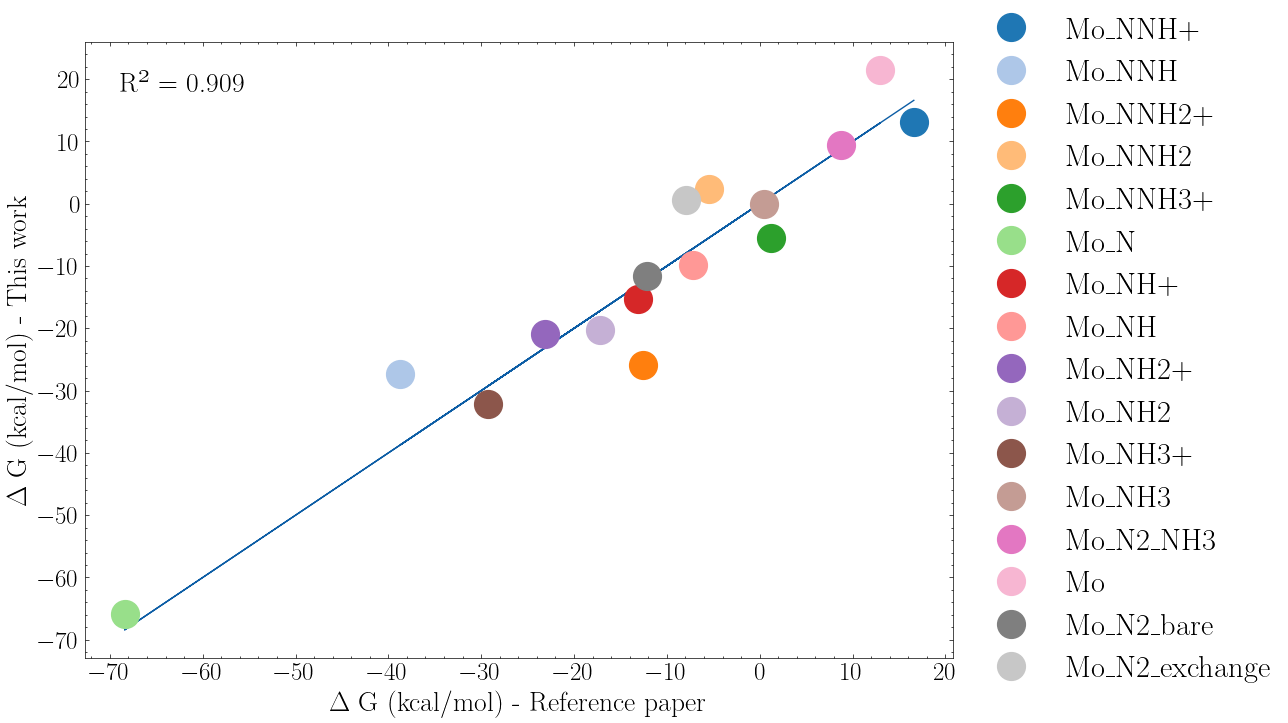

In [289]:
compare_step_vals_G()

In [294]:
def compare_step_vals():

    b3lyp_G = collection["paper_b3lyp_reaction"]
    xtb_thermal = get_xtbreaction_thermal(Path("/home/magstr/Documents/schrock/diagrams_schrock/vibrations_original_xtb/"))

    dict_key = "parts_radius_b3lyp_nogeo"
    diagrams = [
        [
            base / "schrock/diagrams_schrock/dft/b3lyp_sp",
            "orca.out",
            "FINAL SINGLE",
            dicts[dict_key],
        ],
    ]
    # Get the energy dict
    paths = diagrams[0][0].rglob(f"*{diagrams[0][1]}")
    energy = get_energies_Mo(paths=paths, pattern=diagrams[0][2])
    # Convert to kcal/mol from hartree
    energy.update((key, value * HARTREE2KCAL) for key, value in energy.items())
    # Get the energy difference dict
    b3lyp_own = get_delta_gibbs(energies=energy, reactions=diagrams[0][3])  
    #b3lyp_own = combine_dict_values(b3lyp_own, xtb_thermal)
    
    cmap = cm.get_cmap("tab20")
    colors=cmap.colors
    
    b3lyp_G_vals = []
    b3lyp_own_xtbG_vals = []
    label = []
    for key, val in b3lyp_own.items():
        b3lyp_G_vals.append(b3lyp_G[key])
        b3lyp_own_xtbG_vals.append(val)
        label.append(key)
        
    plt.figure(figsize=(14, 8))
    
    
    plt.plot(b3lyp_G_vals, b3lyp_G_vals, "")
    
    for x,y,label,color in zip(b3lyp_G_vals, b3lyp_own_xtbG_vals,label, colors):
        plt.plot(x, y, 'o', label=label, markersize='20', color=color)
     
    plt.ylabel(r"$\Delta$ E (kcal/mol) - This work")
    plt.xlabel(r"$\Delta$ E (kcal/mol) - Reference paper")

    ax = plt.gca()
    
    ### Set legend ouside plot
    ax.xaxis.set_major_locator(MultipleLocator(10))
    ax.yaxis.set_major_locator(MultipleLocator(10))
    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),prop={'size': 22})
    
    ### Add Rsquare
    R2 = r2_score(b3lyp_G_vals, b3lyp_own_xtbG_vals)
    d = {'R² = ':R2}
    text = nice_string_output(d, extra_spacing=2, decimals=3)
    add_text_to_ax(0.04, 0.95, text, ax, fontsize=20)    

    plt.savefig("/home/magstr/Documents/Paper/figures/compare_step_vals.pdf")
    plt.show()

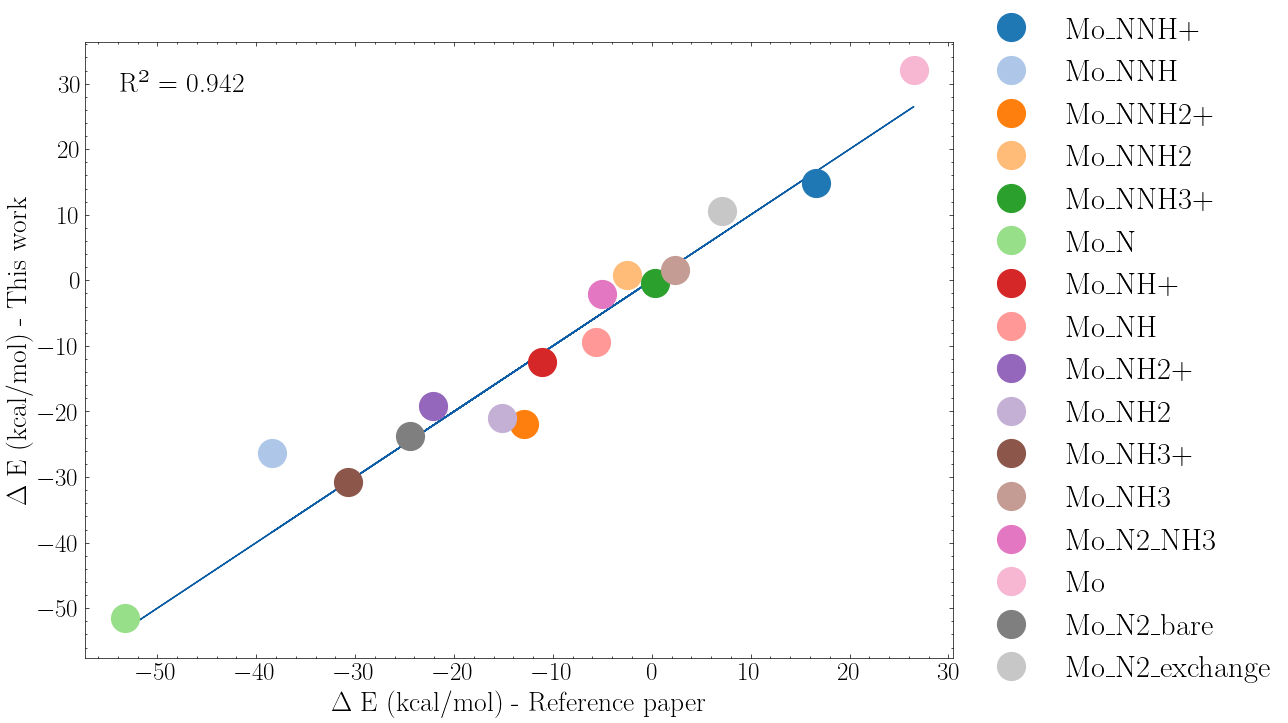

In [295]:
compare_step_vals()

## LAtex tables

In [36]:
def create_latex_tables():

    # Get the dict with all the parts energies.
    parts = read_parts()

    # Example code:
    # https://colab.research.google.com/drive/1Iq10lHznMngg1-Uoo-QtpTPii1JDYSQA?usp=sharing#scrollTo=K7NNR1Vg40Vo

    # Simple header
    headers = ["Structure", "Energy"]

    for key in parts:
        for k, v in parts[key].items():
            parts[key][k] = round(v, 2)

    key = "parts_radius_pbe_noegeo"

    rows = [[k, v] for k, v in parts[key].items()]

    print("Tabulate Table:")
    print(tabulate(rows, headers=headers))

    # Formatting option: floatfmt=".3f"
    print("\nTabulate Latex:")
    print(tabulate(rows, headers=headers, tablefmt="latex", floatfmt=".2f"))

    ### Now we do the same for the Mo energies.

    path = Path(
        "/home/magstr/Documents/schrock/diagrams_schrock/dft/b3lyp_sp/"
    )

    # Get the path to the folders
    paths = path.rglob(f"orca.out")
    energy = get_energies_Mo(paths=paths, pattern="FINAL SINGLE")
    for k, v in energy.items():
        energy[k] = round(v * HARTREE2KCAL, 2)
    rows = [[k, v] for k, v in energy.items()]

    print("U made it, one up")
    # Formatting option: floatfmt=".3f"
    print("\nTabulate Latex:")
    print(tabulate(rows, headers=headers, tablefmt="latex", floatfmt=".2f"))

    return

In [37]:
create_latex_tables()

Tabulate Table:
Structure                   Energy
---------------  -----------------
N2                -68745.6
LuH+             -205372
Lu               -205109
CrCp2+                -1.15097e+06
NH3               -35493.4
CrCp2                 -1.15106e+06
delta_Cp              97.95
delta_Lu             262.22
reaction_energy      -80.26

Tabulate Latex:
\begin{tabular}{lr}
\hline
 Structure       &      Energy \\
\hline
 N2              &   -68745.57 \\
 LuH+            &  -205371.70 \\
 Lu              &  -205109.48 \\
 CrCp2+          & -1150965.01 \\
 NH3             &   -35493.43 \\
 CrCp2           & -1151062.96 \\
 delta\_Cp        &       97.95 \\
 delta\_Lu        &      262.22 \\
 reaction\_energy &      -80.26 \\
\hline
\end{tabular}
U made it, one up

Tabulate Latex:
\begin{tabular}{lr}
\hline
 Structure   &      Energy \\
\hline
 Mo\_NNH+     & -5559414.27 \\
 Mo\_NH2      & -5525528.12 \\
 Mo\_NH3+     & -5525822.53 \\
 Mo\_NH3      & -5525904.42 \\
 Mo\_NNH3+    & -5